In [1]:
FILES_PATH = '/data/in/files/'


In [2]:
# import libraries
import os
import sys
import re

# get files not ending with manifest
script_files = [f for f in os.listdir(FILES_PATH) if re.match(r'^[0-9]+_.+$', f) and not f.endswith('.manifest')]

# create new name for files
rename_dict = {f: re.sub(r'^[0-9]+_(.*)', '\\1', f) for f in script_files}

# rename files
for old, new in rename_dict.items():
    os.rename(f'{FILES_PATH}{old}', f'{FILES_PATH}{new}')
    print(f'In {FILES_PATH}, {old} renamed to {new}')
    
# add FILES_PATH to sys.path
sys.path.append(FILES_PATH)


In [3]:
METHOD = "RF"
MODALITY = "NAME_BRIEF"
PRE = "fasttext"


In [4]:
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

from fasttext import FastText


In [5]:
mats = pd.read_csv("in/tables/MATERIALS_FOR_CLASSIFICATION_CLEAN.csv")
cats = pd.read_csv("in/tables/MATERIAL_CATEGORY_FOR_CLASSIFICATION.csv")

df = pd.merge(mats,cats,on=["MATERIAL_ODS_ID","SHOP"])

def create_category_dict(df):
    return df.groupby("CATEGORY_ID").CATEGORY_PATH.unique().to_dict()
category_dict = create_category_dict(df)

# should be applied after category_decoder_dict
df = df[~df.MATERIAL_ID.duplicated()].reset_index(drop=True).copy()

for k,v in category_dict.items():
    df.loc[df.CATEGORY_ID == k,"CATEGORY_PATH_FIX"] = v[0]

In [6]:
from sh import gunzip
from sklearn.preprocessing import FunctionTransformer

# unzip fastext models
gunzip(f"{FILES_PATH}"+"cc.cs.300.bin.gz")

ErrorReturnCode_1: 

  RAN: /bin/gunzip /data/in/files/cc.cs.300.bin.gz

  STDOUT:


  STDERR:
gzip: /data/in/files/cc.cs.300.bin.gz: No such file or directory


In [7]:
fasttext = FastText.load_model(f"{FILES_PATH}"+"cc.cs.300.bin")



def encode_dataframe(X):
    return np.array([fasttext.get_sentence_vector(i) for i in X])

transform_text = FunctionTransformer(encode_dataframe)

In [8]:
df = df[df.CATEGORY_PATH.str.startswith("Hobby a zahrada > Zahradní technika > Se")].copy()

In [9]:
ft_vectors = [fasttext.get_sentence_vector(i) for i in df.NAME_BRIEF]

In [10]:
from sklearn.manifold import TSNE

In [16]:
df.CATEGORY_ID.unique().shape

(12,)

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, random_state=0).fit(ft_vectors)
# We can extract labels from k-cluster solution and store is to a list or a vector as per our requirement
Y=kmeans.labels_ # a vector

In [63]:
import random
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(12)]
color = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"] + color[:3]

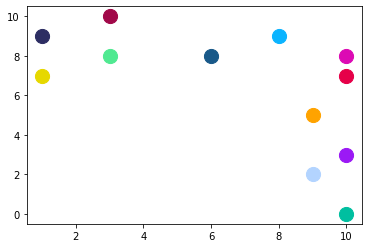

In [64]:
for i in range(12):
    plt.scatter(random.randint(0, 10), random.randint(0,10), c=color[i], s=200)

plt.show()

In [65]:
def pick_color(i):
    return color[i]

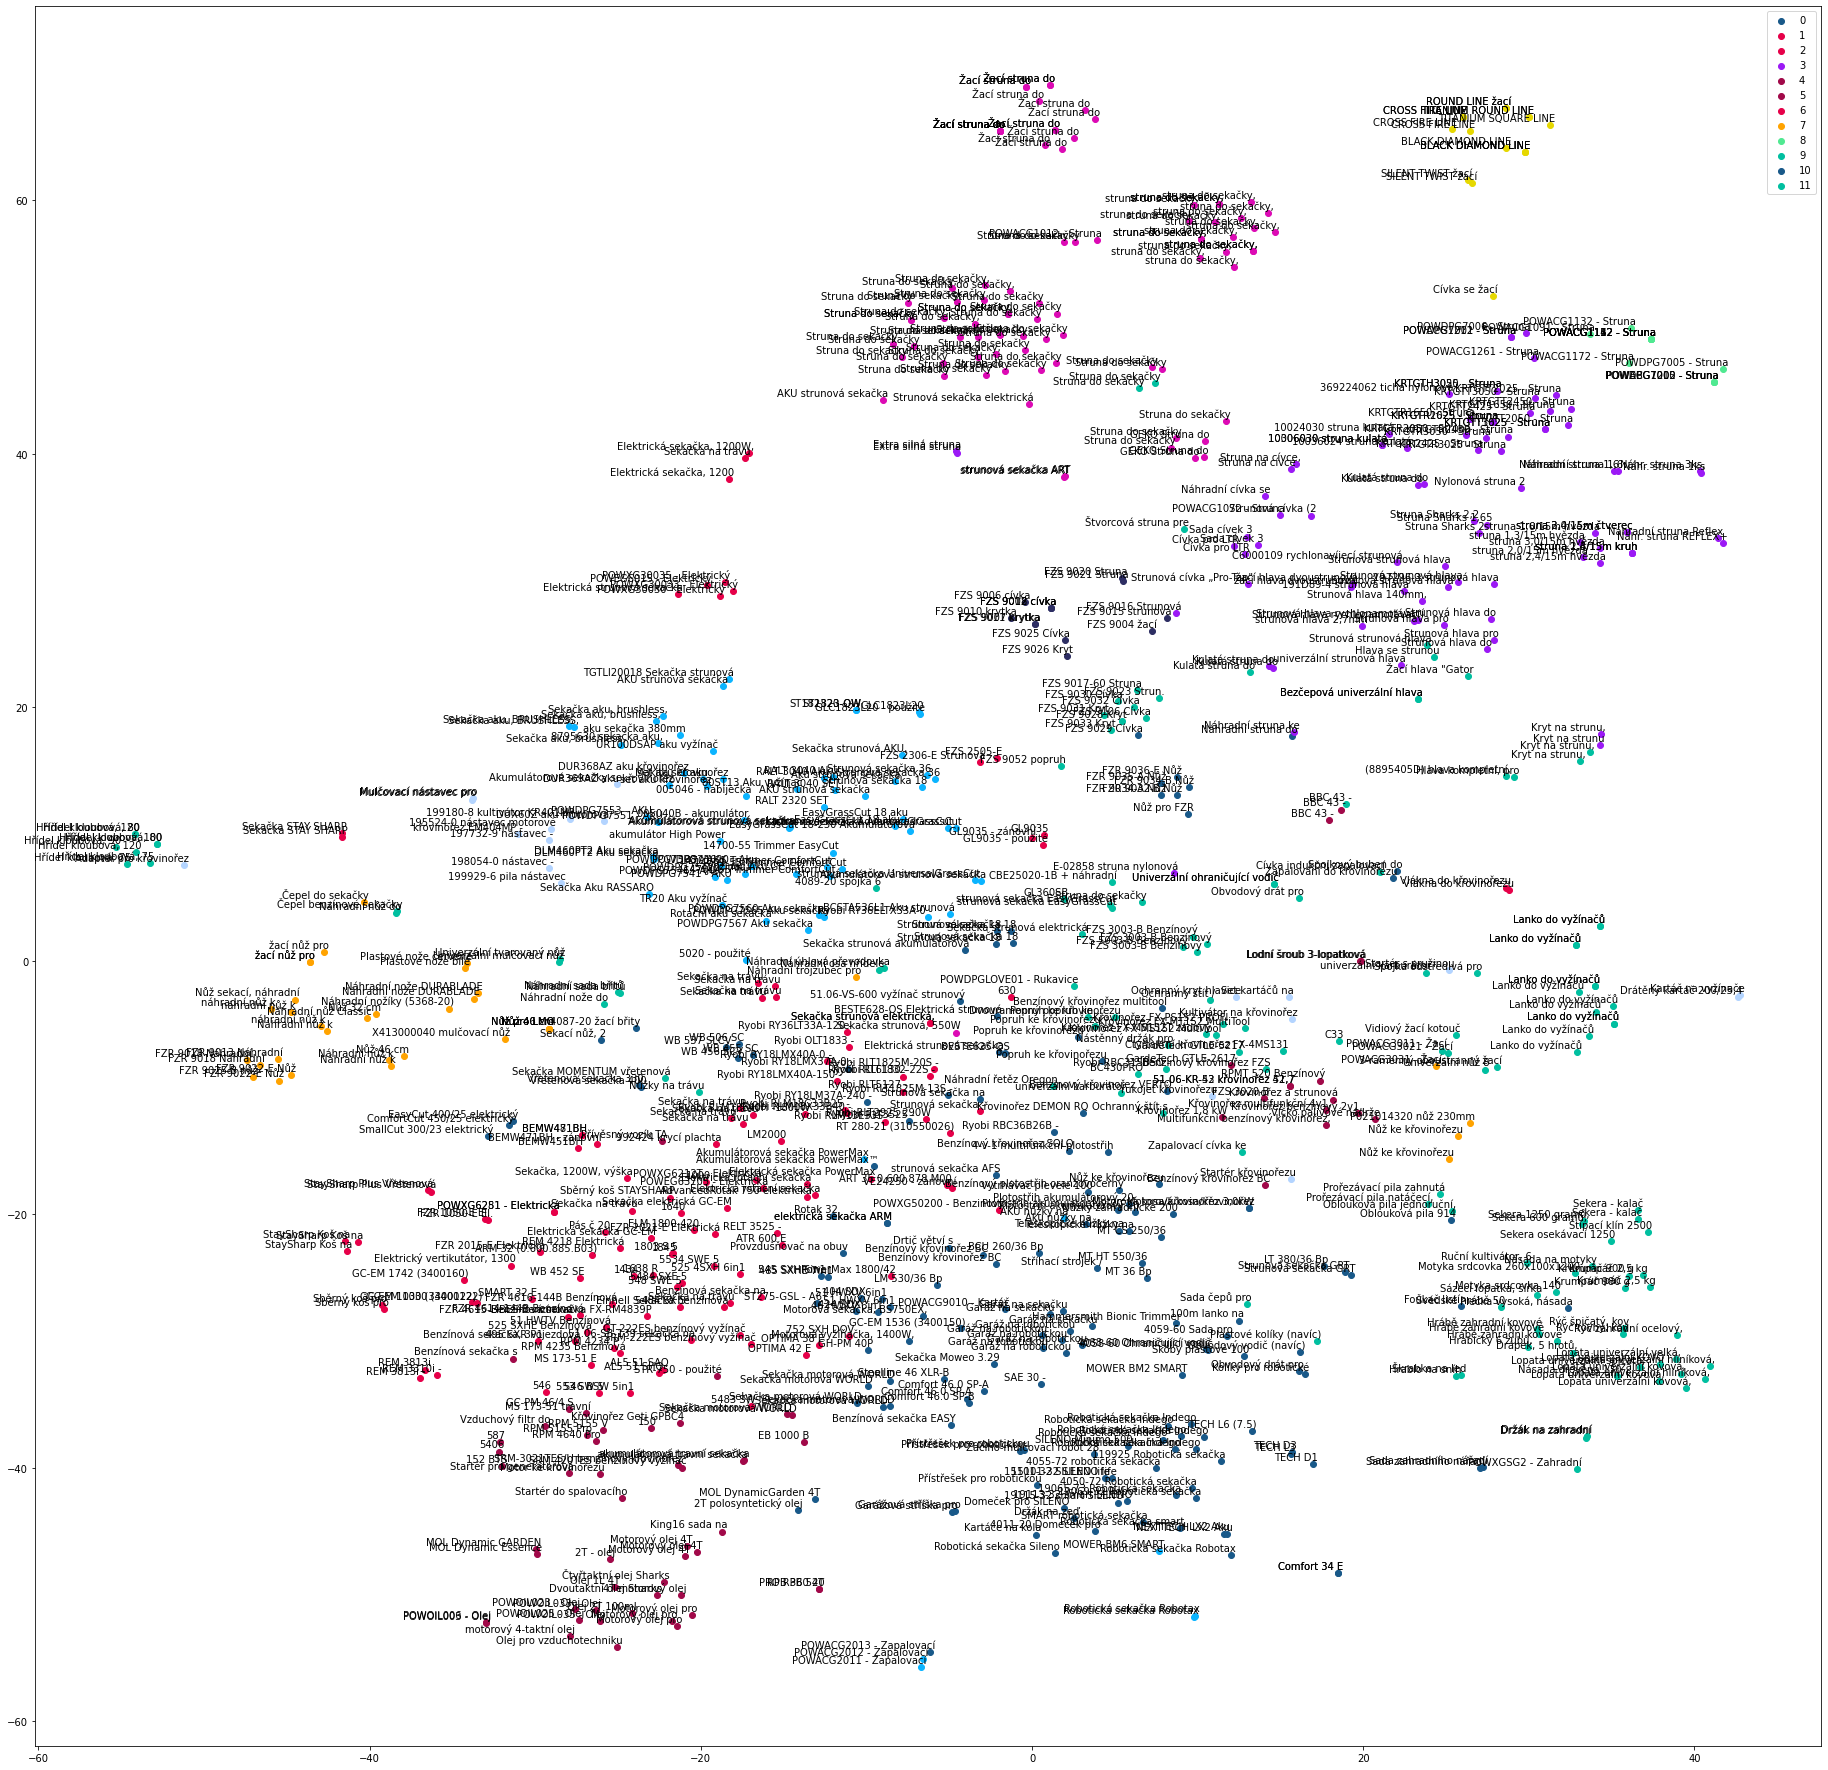

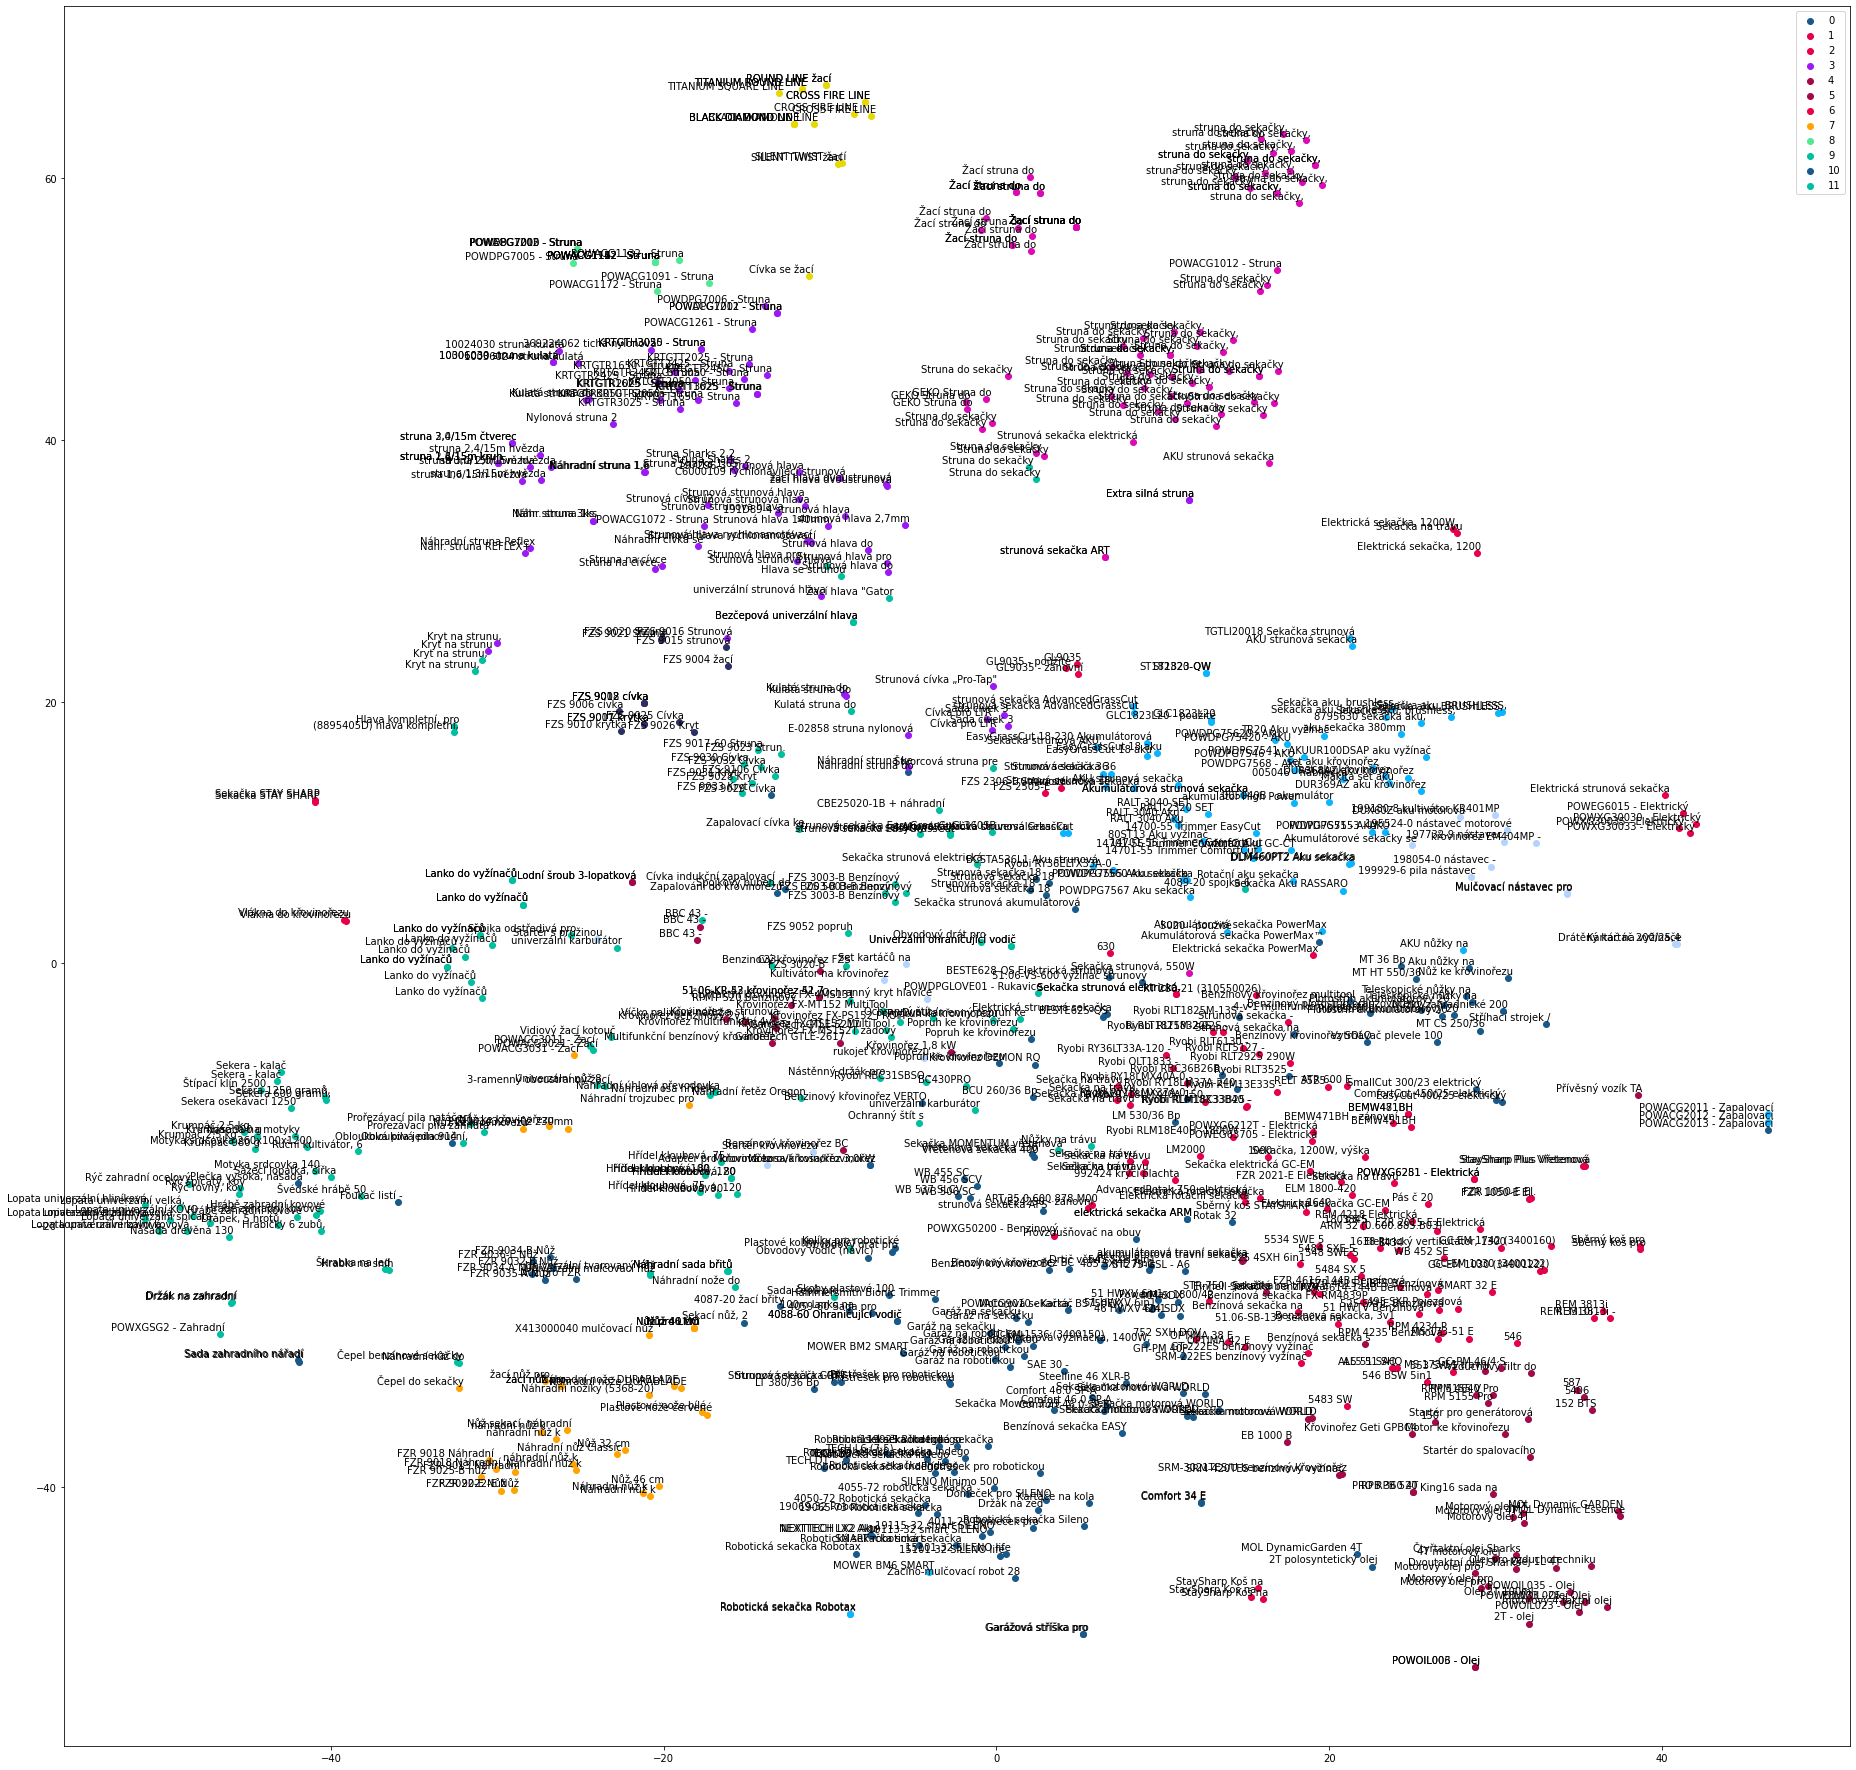

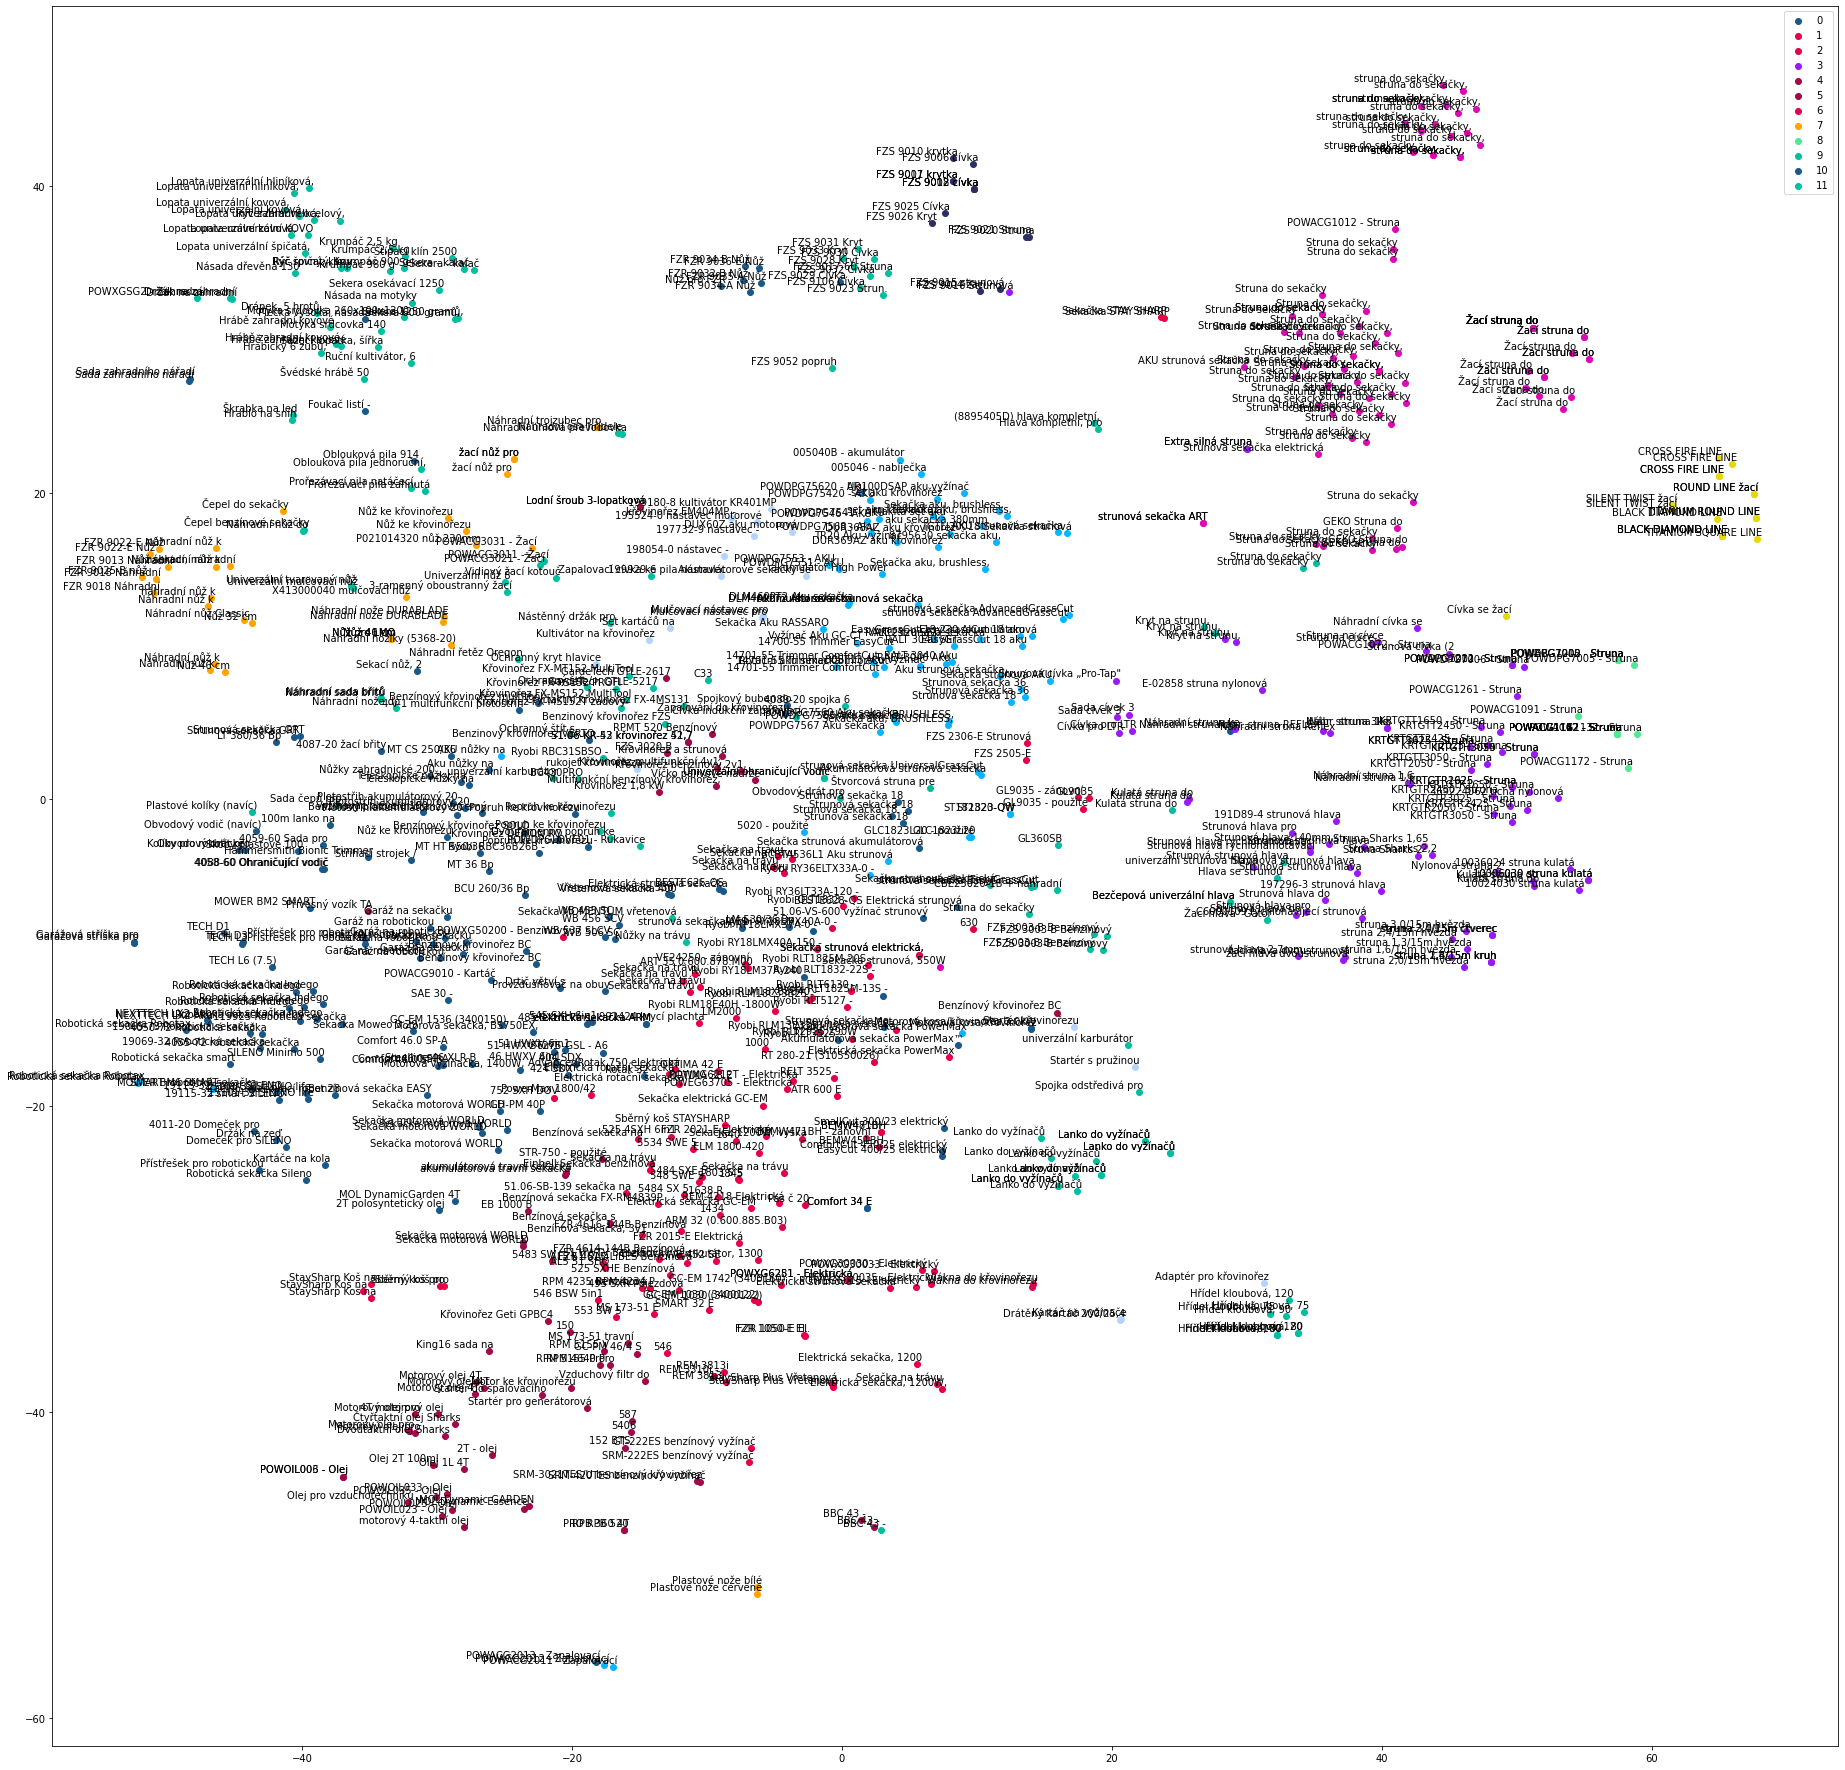

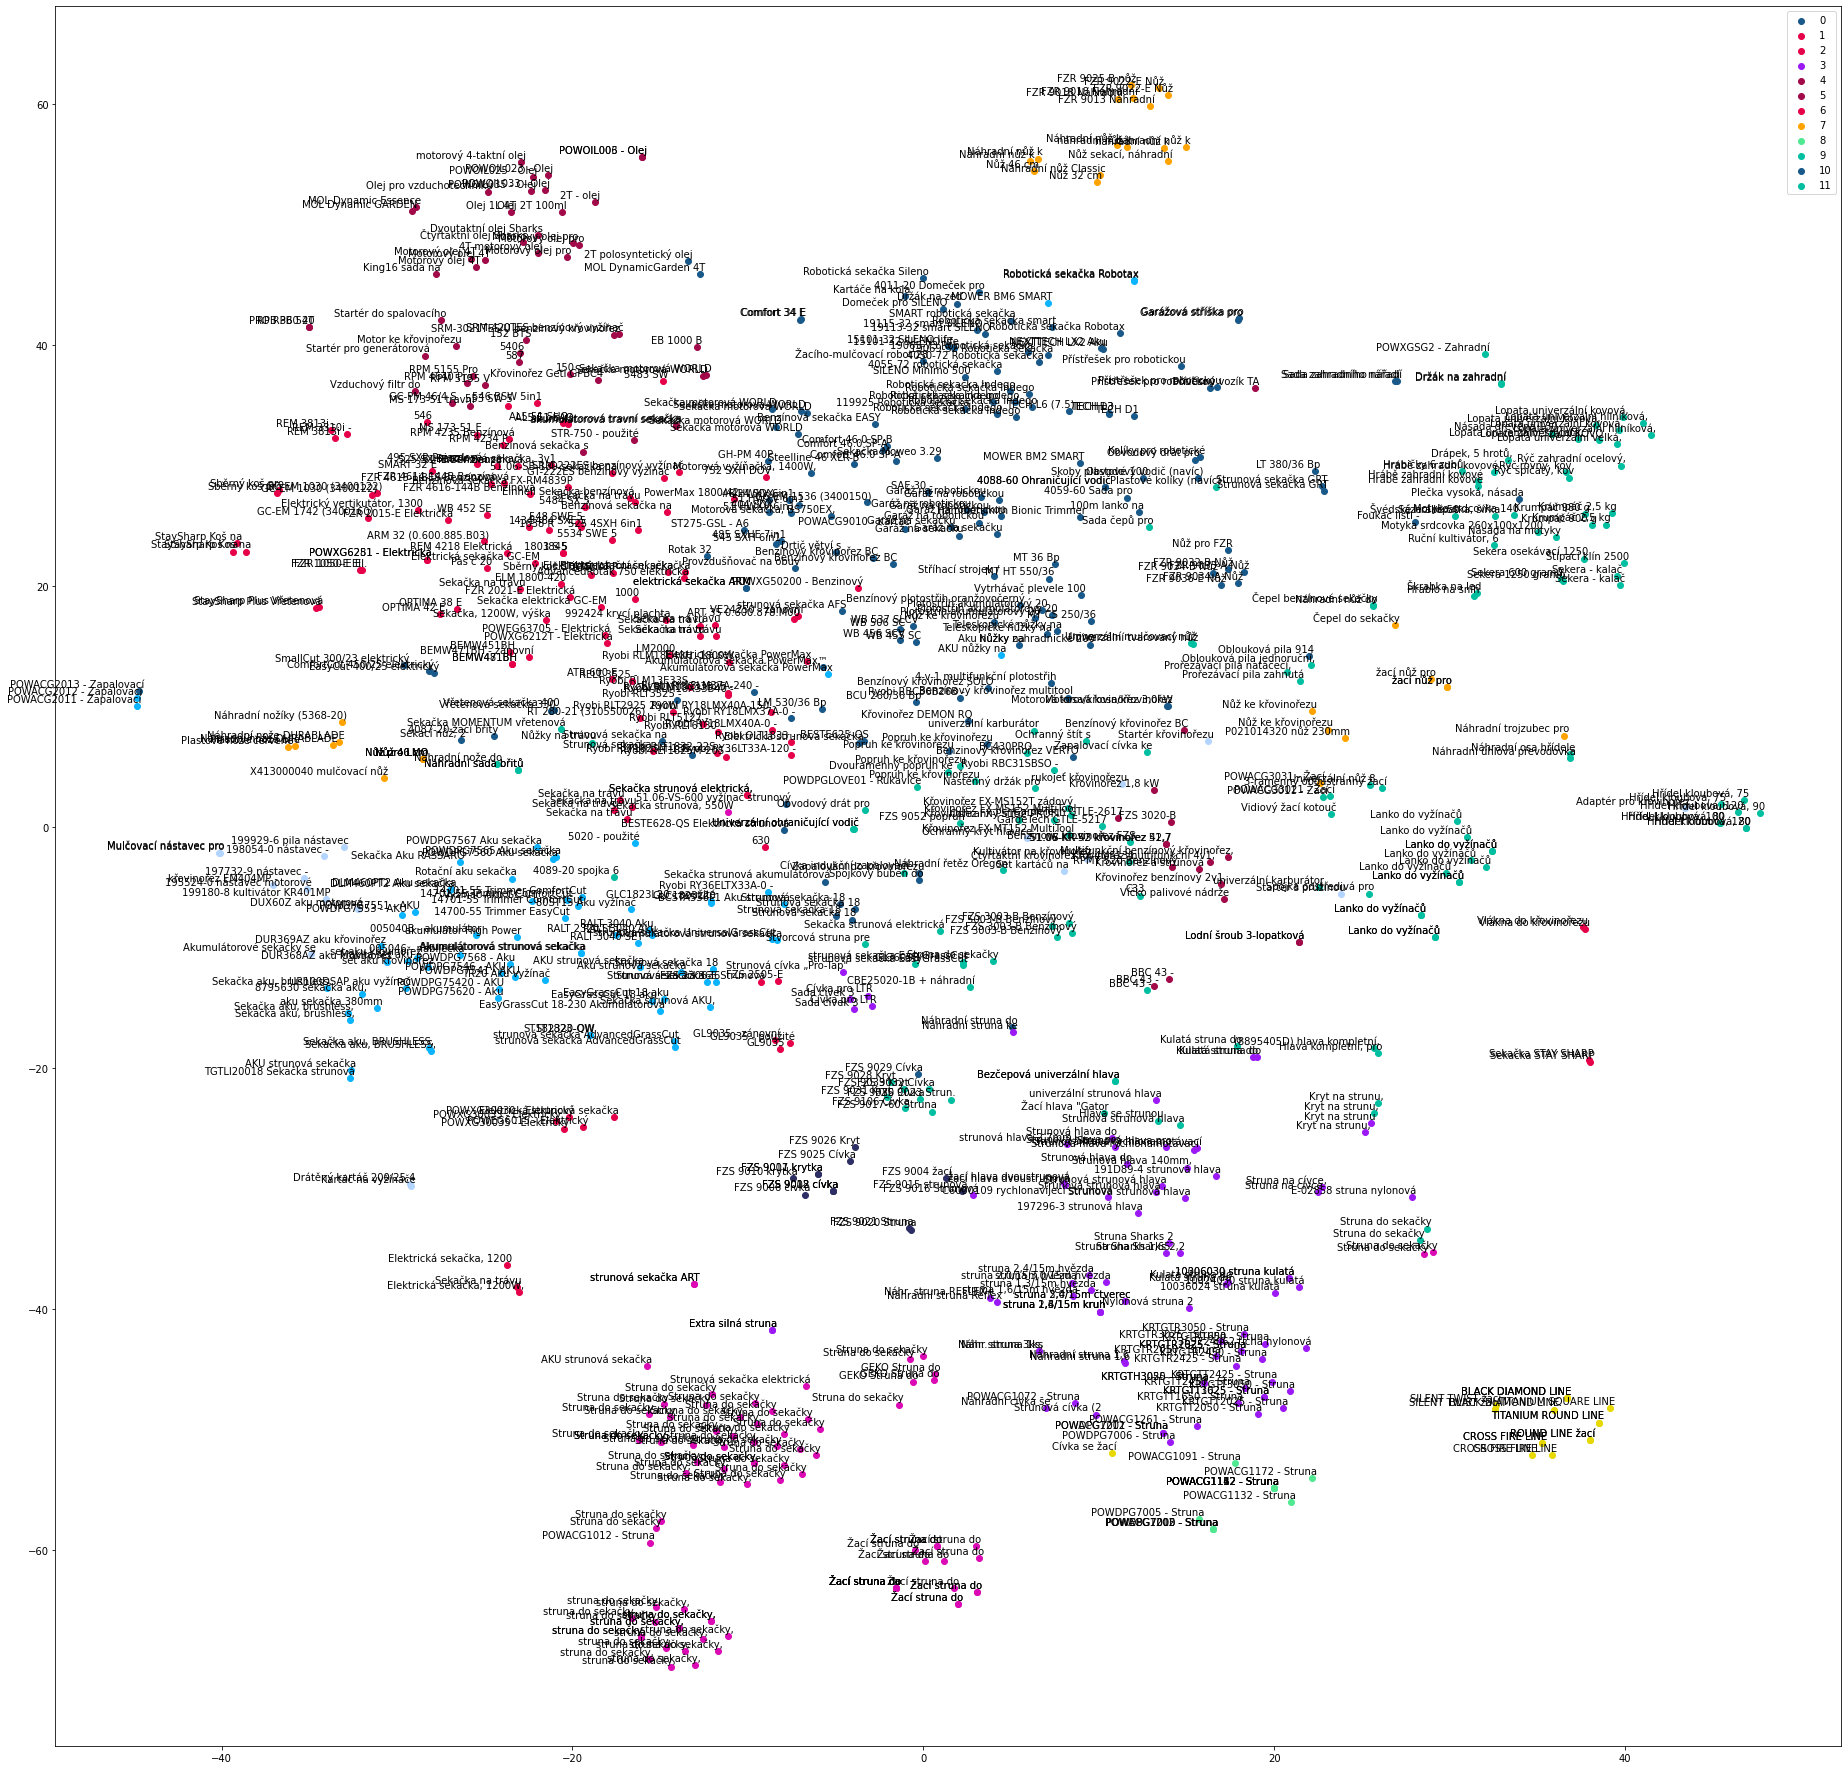

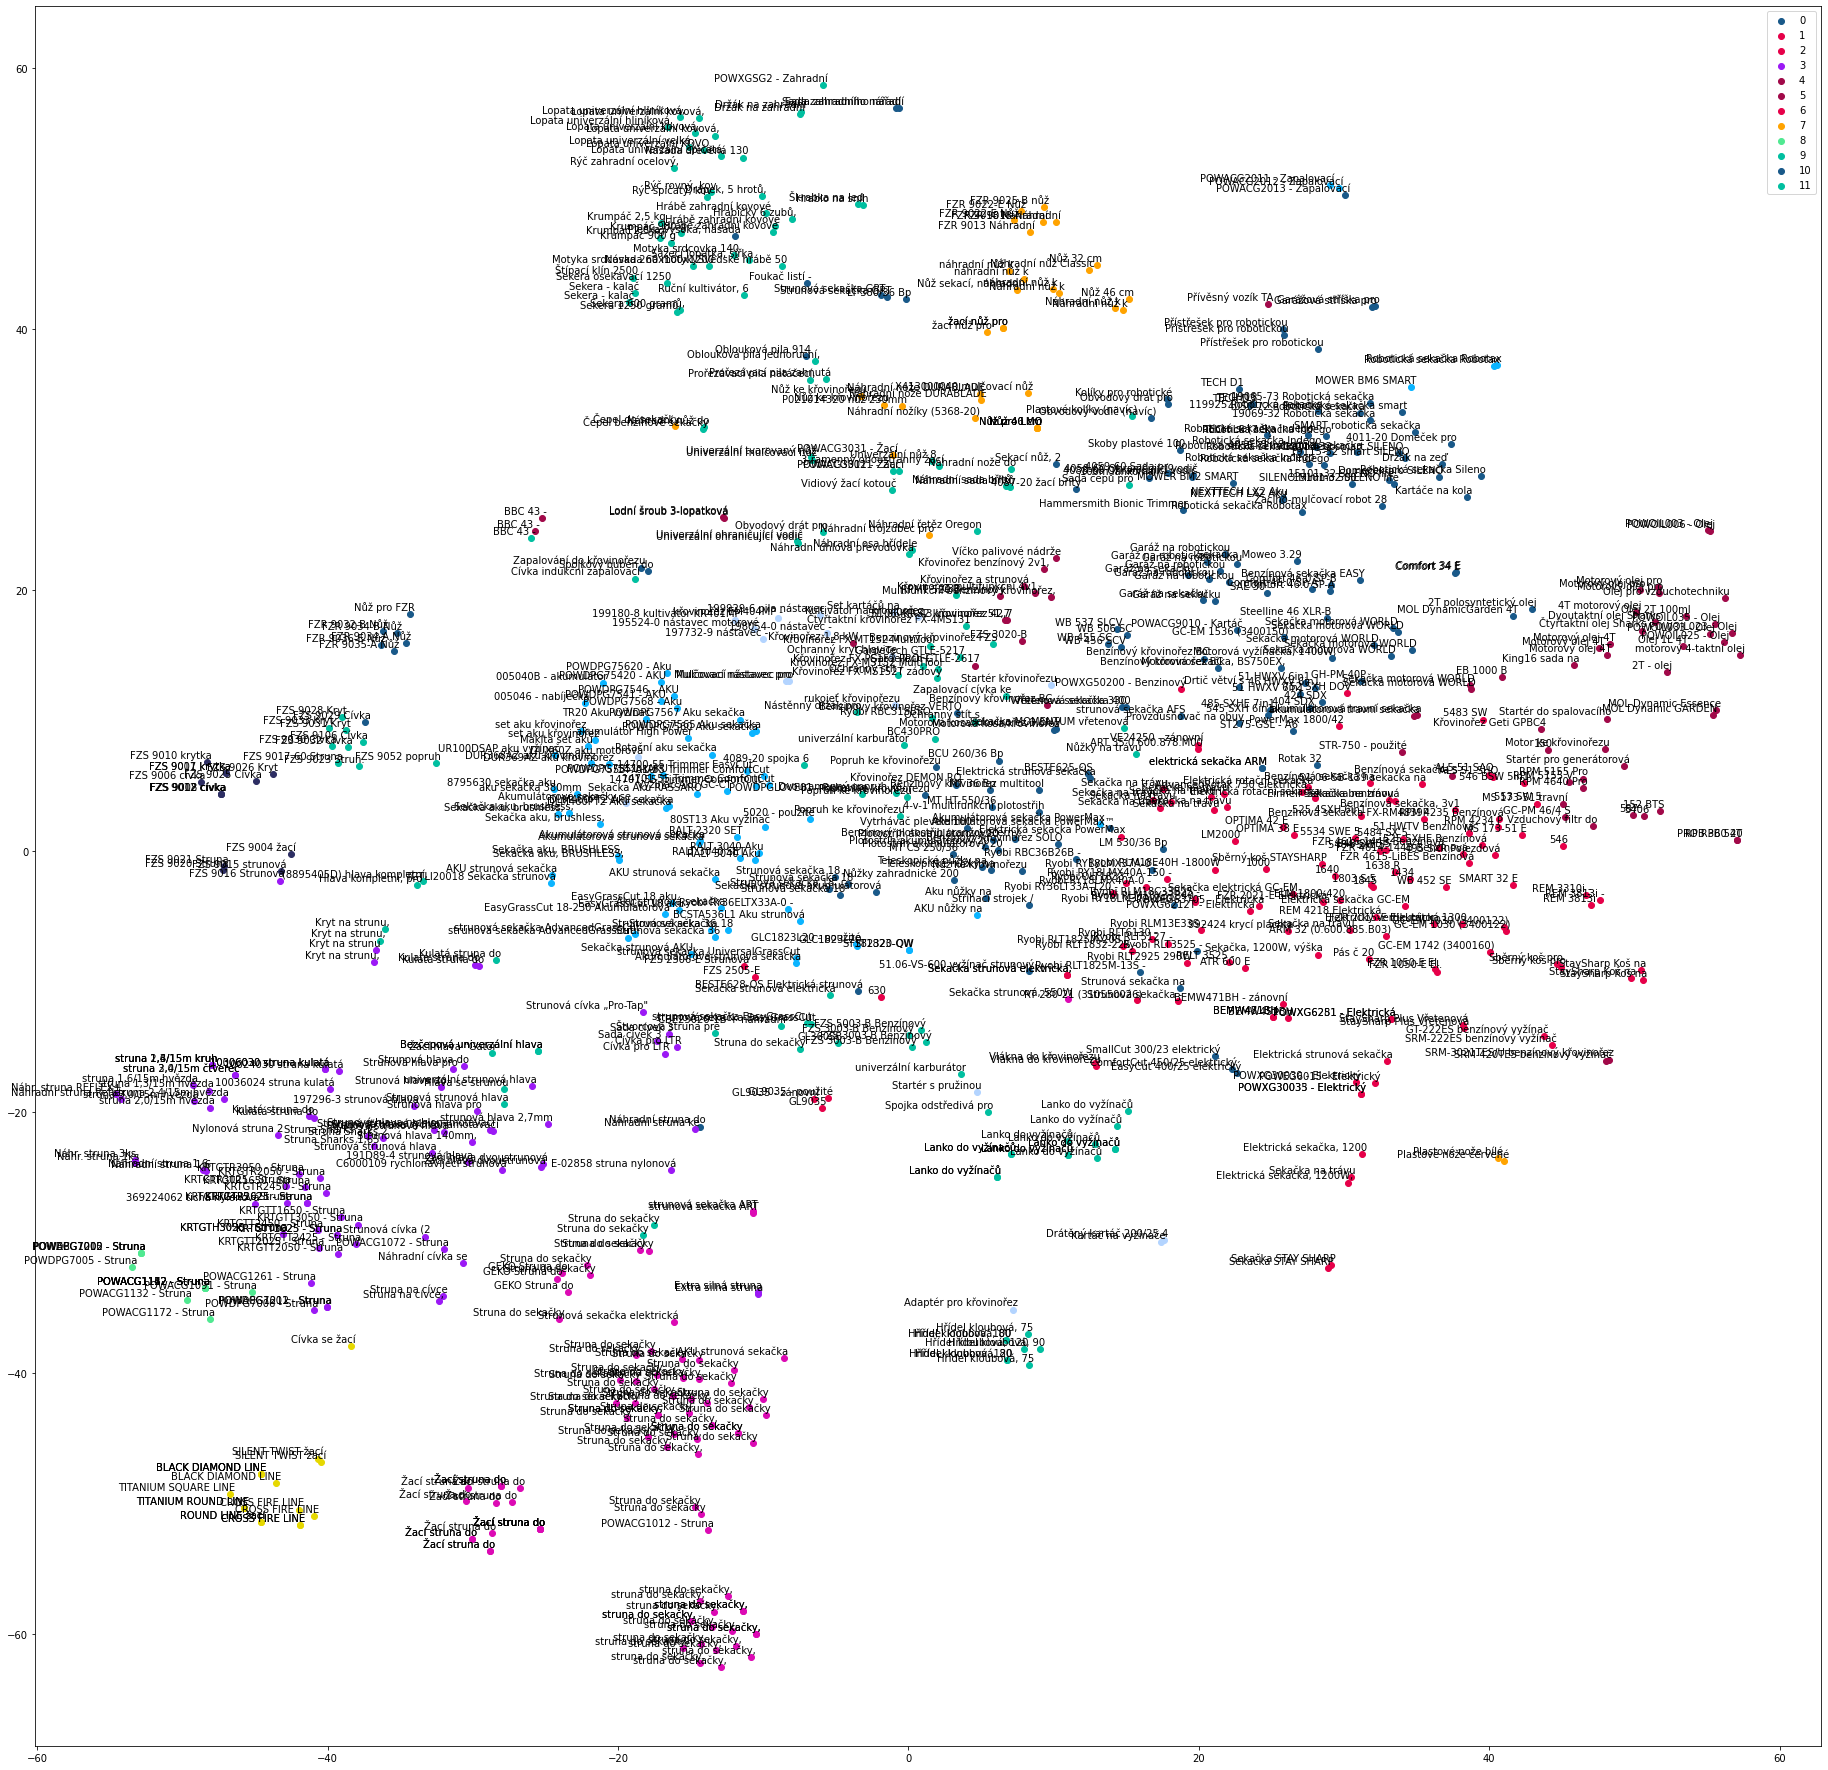

In [69]:
import matplotlib.pyplot as plt
for j in range(5):
    tsne = TSNE(n_components=2, learning_rate=10, perplexity=30, angle=0.2, n_iter=2000).fit_transform(ft_vectors)


    x=[]
    y=[]

    [x.append(x_i) for x_i,_ in tsne]
    [y.append(y_i) for _,y_i in tsne]

    labels = df.NAME.str.split().apply(lambda x: " ".join(x[:3])).values

    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],c=pick_color(Y[i]))
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.legend(list(range(12)))        
    plt.savefig(f'TSNE_text_{j}.png', dpi=120)

# medium vizualize

In [39]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

# Importing matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=18, random_state=0).fit(ft_vectors)
# We can extract labels from k-cluster solution and store is to a list or a vector as per our requirement
Y=kmeans.labels_ # a vector

z = pd.DataFrame(Y.tolist()) # a list
# Fit the model using t-SNE randomized algorithm
digits_proj = TSNE(random_state=RS).fit_transform(ft_vectors)

In [48]:
df["cluster"] = Y

In [62]:
def get_most_common_words(df):
    return df.NAME.str.split().apply(lambda x: " ".join(x[:3])).value_counts().index[0]
df.groupby("cluster").apply(get_most_common_words)

cluster
0                        BBC 43 -
1             Strunová sekačka 18
2                  Žací struna do
3                  náhradní nůž k
4               Struna do sekačky
5     14701-55 Trimmer ComfortCut
6             POWACG1162 - Struna
7              BLACK DIAMOND LINE
8        Robotická sekačka Indego
9                Sekačka na trávu
10        Strunová strunová hlava
11         Mulčovací nástavec pro
12     Lopata univerzální kovová,
13                  FZS 9004 žací
14         Sekačka motorová WORLD
15             struna do sekačky,
16               Motorový olej 4T
17           Náhr. struna REFLEX+
dtype: object

In [57]:
test = df.query("cluster == 10").copy()

'Strunová strunová hlava'

In [43]:

# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 18))

    # We create a scatter plot.
    f = plt.figure(figsize=(32, 32))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(18):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

def scatter_2(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 11))

    # We create a scatter plot.
    f = plt.figure(figsize=(48, 48))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(11):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(PMCAT_List[i]), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


/tmp/ipykernel_136/569631964.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])


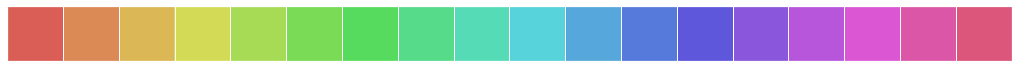

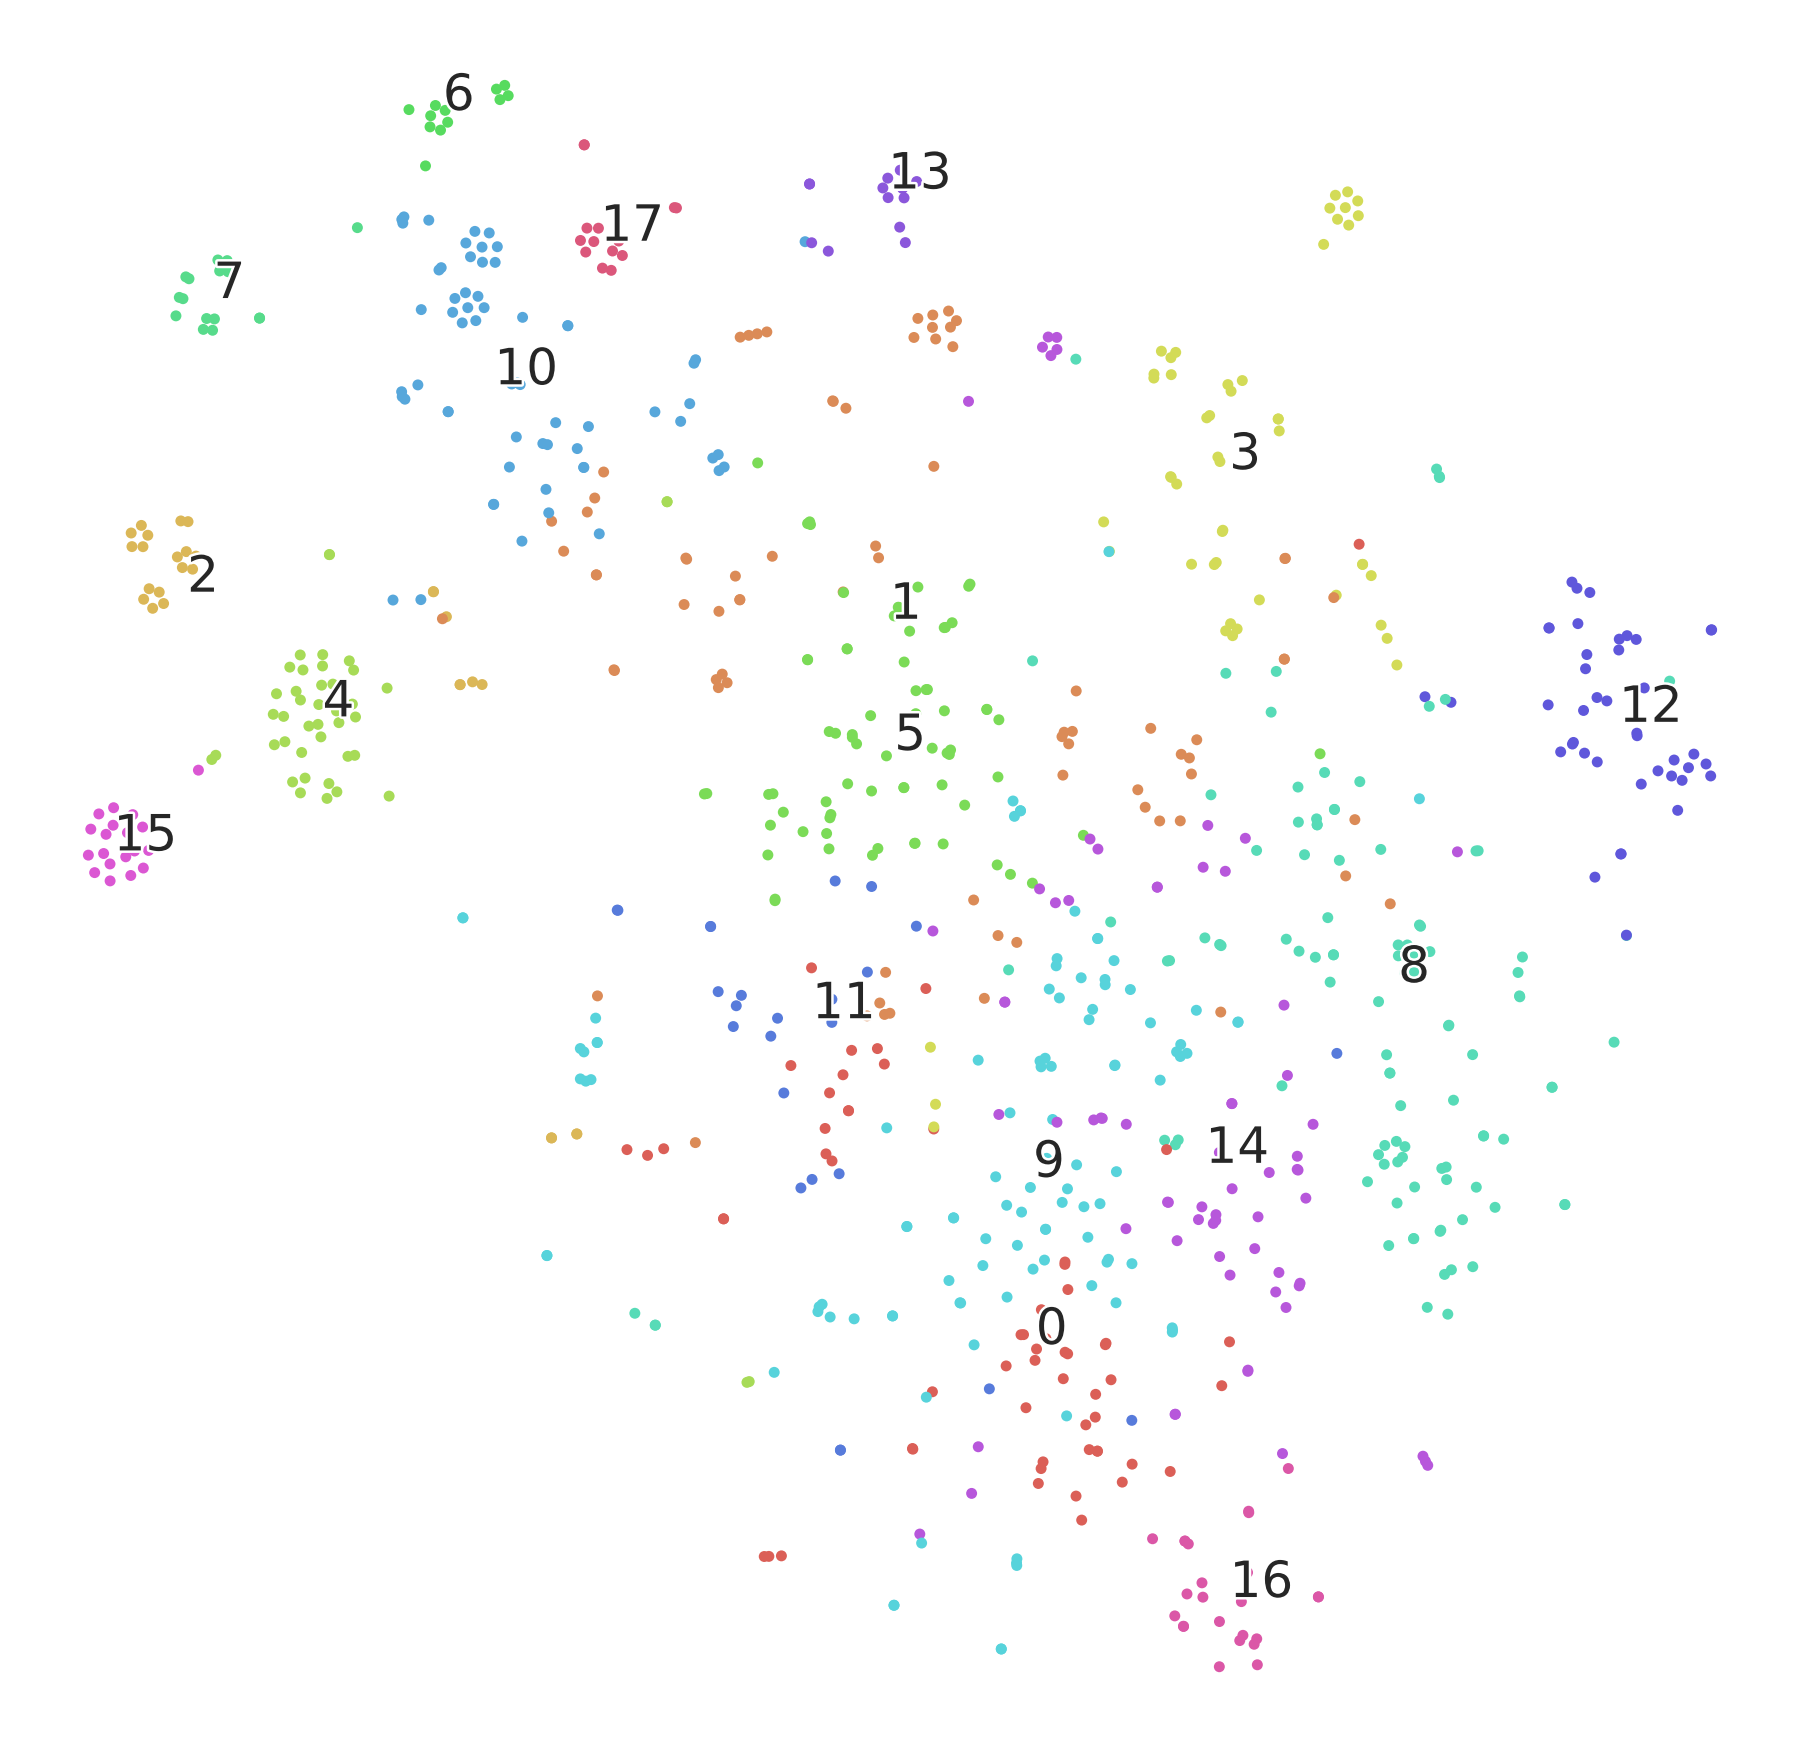

In [46]:

print(list(range(0,18)))
sns.palplot(np.array(sns.color_palette("hls", 18)))
scatter(digits_proj, Y)
plt.savefig('digits_tsne-generated_18_cluster.png', dpi=120)


In [8]:
too_small_categories_df = remove_too_small_categories(df)
train, test = create_datasets(df,"CATEGORY_PATH_FIX")
train = over_sample(train)

Len of df before: 242110
Len of df after: 240998
Appending 8529 of new samples


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

algorithms = {"RF":RandomForestClassifier(),
             "LR":LogisticRegression(max_iter=10),
             "XGB":XGBClassifier()}

METHOD = "LR"

pipeline = Pipeline([("fasttext",transform_text),
                     (f"{METHOD}", algorithms[METHOD])])

train_sample = []
# for category in train.CATEGORY_ID.unique():
#     train_category = train.query("CATEGORY_ID == @category")
#     train_sample.append(train_category.sample(frac=0.2,random_state=1))

if not len(train_sample) == 0:
    train = pd.concat(train_sample)  
X = train["NAME_BRIEF"]
y_raw = train.CATEGORY_ID


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

In [23]:
scores, pred_df = evaluate_results(pipeline,
                                   test,
                                   "CATEGORY_ID",
                                   "NAME_BRIEF",
                                  label_encoder)

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
scores

(0.21353111494988264, 0.3309681881051176, 0.21135698216922813)

# fasttext similarity

In [10]:
pip install faiss-cpu

     |████████████████████████████████| 8.5 MB 16.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/default/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import faiss

In [32]:
def get_n_similar_materials(features, k=50):
    
    index = faiss.IndexFlatIP(features.shape[1])
    faiss.normalize_L2(features)
    index.add(features)

    distances, neighbours = index.search(features, k)
    
    return distances, neighbours

In [28]:
train_vector = encode_dataframe(train.NAME_BRIEF)

In [34]:
test_vector = encode_dataframe(test.NAME_BRIEF)

In [82]:
index = faiss.IndexFlatIP(train_vector.shape[1])
faiss.normalize_L2(train_vector)
index.add(train_vector)
faiss.write_index(index, "faiss_index.pkl")

In [37]:
index = faiss.read_index("faiss_index.pkl")

In [38]:
faiss.normalize_L2(test_vector)
nearest_neighbours = index.search(test_vector, 10)

In [39]:
predictions = [train.iloc[neighbour].CATEGORY_PATH.value_counts().index[0] for neighbour in nearest_neighbours[1]]

In [40]:
precision_recall_fscore_support(test.CATEGORY_PATH, predictions, average="weighted")

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7807155359578921, 0.7843015214384509, 0.7781421591027484, None)

In [62]:
faiss.normalize_L2(test_vector[:2])

# neureal network

In [24]:
from sklearn.neural_network import MLPClassifier

In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(50))

In [51]:
from sklearn.preprocessing import LabelEncoder
X = train_vector
y_raw = train.CATEGORY_ID
y_raw_test = test.CATEGORY_ID

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
y_test = label_encoder.fit_transform(y_raw_test)
# mlp.fit(X,y)

In [82]:
import joblib

In [36]:
test.iloc[:1]

MATERIAL_ID  MATERIAL_ODS_ID  SHOP                              NAME  \
176974  100021573192       1062779956  MACZ  Nabíječka Makita BDF442RFE s USB   

                                    BRIEF                NAME_BRIEF  \
176974  14,4V šedá 185mm x 160mm x 80mm\n  nabíječk makit usb ; šed   

                                         NAME_DESCRIPTION  \
176974  nabíječk makit usb ; power nabíječk usb nářad ...   

                                   NAME_BRIEF_DESCRIPTION IS_MAIN  \
176974  nabíječk makit usb šed power nabíječk usb nářa...       t   

        CATEGORY_ID                                      CATEGORY_PATH  \
176974          128  Hobby a zahrada > Nářadí elektrické > Přísluše...   

                                             CATEGORY_URL VISIBLE  \
176974  https://www.mall.cz/elektricke-naradi-prisluse...       t   

                              CATEGORY_NAME  \
176974  Příslušenství k elektrickému nářadí   

                                        CATEGORY_PATH_FIX  
176974  Hobby a zahrada > Nářadí elektrické > Přísluše...

In [37]:
label_encoder.inverse_transform(mlp.predict(test_vector[:1]))

array([128])

In [83]:
joblib.dump(mlp, "mlp_sklearn.pkl")

['mlp_sklearn.pkl']

In [35]:
predictions = mlp.predict(test_vector)

In [40]:
precision_recall_fscore_support(test.CATEGORY_ID, label_encoder.inverse_transform(mlp.predict(test_vector)), average="weighted")

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7484775759600176, 0.7611756569847856, 0.7411297415472553, None)

# Torch

In [ ]:
pip install torch

In [32]:
import torch

ModuleNotFoundError: No module named 'torch'

In [ ]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

In [ ]:
model.train()
epoch = 20
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

# tensorflow

In [41]:
pip install tensorflow

     |███████████████████▍            | 296.2 MB 137.5 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 489.7 MB 5.9 kB/s s eta 0:00:01
     |████████████████████████████████| 81 kB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 126.5 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.8 MB/s s eta 0:00:01
     |████████████████████████████████| 463 kB 127.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 11.2 MB/s  eta 0:00:01
     |████████████████████████████████| 126 kB 129.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 14.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 116.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 107.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 110.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 118.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 16.2 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 119.4 MB/s eta 0:00:01
     |█████████████████

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow as tf

In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(train.CATEGORY_ID.unique().shape[0])
])

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
model.fit(X, y, epochs=10,validation_data=(test_vector, y_test))

Epoch 1/10
5539/5539 [==============================] - 17s 3ms/step - loss: 1.7279 - accuracy: 0.6297 - val_loss: 0.9267 - val_accuracy: 0.7686
Epoch 2/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.8154 - accuracy: 0.7924 - val_loss: 0.7003 - val_accuracy: 0.8206
Epoch 3/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.6392 - accuracy: 0.8342 - val_loss: 0.6100 - val_accuracy: 0.8444
Epoch 4/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.5426 - accuracy: 0.8584 - val_loss: 0.5600 - val_accuracy: 0.8522
Epoch 5/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.4772 - accuracy: 0.8743 - val_loss: 0.5083 - val_accuracy: 0.8691
Epoch 6/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.4279 - accuracy: 0.8869 - val_loss: 0.4845 - val_accuracy: 0.8751
Epoch 7/10
5539/5539 [==============================] - 17s 3ms/step - loss: 0.3887 - accuracy: 0.8959 - val_loss: 0.4648 - val_ac

In [104]:
predictions = model.predict(test_vector)

In [105]:
predictions = np.argmax(predictions,axis=1)

In [107]:
model.save('FFNN_256')

INFO:tensorflow:Assets written to: FFNN_256/assets


In [91]:
precision_recall_fscore_support(y_test, predictions, average="weighted")

(0.8920114492560526, 0.890027662517289, 0.8885721339746668, None)

In [100]:
precision_recall_fscore_support(y_test, predictions, average="weighted")

(0.8800284611102003, 0.8756984785615491, 0.8743789590064149, None)

In [106]:
precision_recall_fscore_support(y_test, predictions, average="weighted")

(0.8973216160687406, 0.8947302904564315, 0.8929054162681139, None)

# Hierarchical

In [422]:
df.CATEGORY_PATH_FIX = df.CATEGORY_PATH_FIX.str.replace("Hobby a zahrada > ","")
df["CATEGORY_LEVEL"] = df.CATEGORY_PATH_FIX.str.split(" > ").apply(lambda x: len(x))
df["2ND_LEVEL_CAT"] = df.CATEGORY_PATH_FIX.str.split(" > ").apply(lambda x: x[0])
df["3ND_LEVEL_CAT"] = df.CATEGORY_PATH_FIX.str.split(" > ").apply(lambda x: " > ".join(x[:2]) if len(x) > 2 else None)
df["4ND_LEVEL_CAT"] = df.CATEGORY_PATH_FIX.str.split(" > ").apply(lambda x: " > ".join(x[:3]) if len(x) > 3 else None)

In [403]:
category_models_2ND = {}
for i in df["2ND_LEVEL_CAT"].unique():
    if not i == None:
        df_cat = df[df.CATEGORY_PATH_FIX.str.startswith(i+" ")].copy()
        nodes = df_cat.CATEGORY_PATH_FIX.unique().shape[0] - 1
        pieces = df_cat.shape[0]
        if nodes > 0:
            category_models_2ND[i] = [nodes,pieces]

In [404]:
category_models_3ND = {}
for i in df["3ND_LEVEL_CAT"].unique():
    if not i == None:
        df_cat = df[df.CATEGORY_PATH_FIX.str.startswith(i+" ")].copy()
        nodes = df_cat.CATEGORY_PATH_FIX.unique().shape[0] - 1
        pieces = df_cat.shape[0]
        if nodes > 1:
            category_models_3ND[i] = [nodes,pieces]

In [405]:
category_models_4ND = {}
for i in df["4ND_LEVEL_CAT"].unique():
    if not i == None:
        df_cat = df[df.CATEGORY_PATH_FIX.str.startswith(i+" ")].copy()
        nodes = df_cat.CATEGORY_PATH_FIX.unique().shape[0] - 1
        pieces = df_cat.shape[0]
        if nodes > 1:
            category_models_4ND[i] = [nodes,pieces]

In [406]:
models = pd.concat([pd.DataFrame(category_models_2ND).T,
pd.DataFrame(category_models_3ND).T,
pd.DataFrame(category_models_4ND).T,
pd.DataFrame(category_models).T]).reset_index()

In [407]:
models = models[~models.duplicated()].copy()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

hierarchical_dict = {}
predictions = []
results = []

for row in models.itertuples():
    name, nodes, pieces = row[1:]
    df_model = df.loc[df.CATEGORY_PATH_FIX.str.startswith(name)].copy()
    level = len(name.split(">"))
    
    models_below = models[models["index"].str.startswith(name)]["index"].values
    category_change_name = set([" > ".join(i.split(" > ")[:level+1]) for i in models_below if len(i.split(">")) > 1])
    if len(models_below) > 1:
        for other_model in models_below:
            if name == other_model:
                continue
            df_model.loc[df_model.CATEGORY_PATH_FIX.str.startswith(other_model),"CATEGORY_PATH_FIX"] = other_model

    algorithms = {"RF":RandomForestClassifier(),
                 "LogReg":LogisticRegression(),
                 "XGB":XGBClassifier()}

    pipeline = Pipeline([("fasttext",transform_text),
                         (f"{METHOD}", algorithms[METHOD])])

    

    X = train["NAME_BRIEF"]
    y_raw = train.CATEGORY_ID

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)
    print(f"Fitting model: {name} with {str(algorithms[METHOD])}")
    pipeline.fit(X,y)
    
    scores, pred_df = evaluate_results(pipeline,
                                       test,
                                       "CATEGORY_ID",
                                       "NAME_BRIEF")
    
    pred_df["MODEL"] = name

    results = [name]+[level] + [i for i in scores]
    results_df = pd.DataFrame(results,index=["MODEL","LEVEL","P","R","F1"]).T
    
    hierarchical_dict[name] = pipeline
    
    predictions.append(pred_df).
    results.append(results_df)
    

pd.concat(predictions).to_csv("out/tables/PREDICTIONS.csv",index=False)
pd.concat(results).to_csv("out/tables/RESULTS.csv",index=False)

joblib.dump(hierarchical_dict, 'out/files/ROMAN_DP_hierarch_models.pkl')

SyntaxError: invalid syntax (2171943196.py, line 53)